In [63]:
# %load contingency.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import tempfile

import tensorflow as tf
import numpy as np
from numpy import random as nprandom

from sklearn.metrics import roc_curve, auc

# Training Parameters
learning_rate = 0.001
num_steps = 200
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 2 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units
num_adversarial = 10 #how many adversarial examples should be generated (if any) per iteration

# Adapted from https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

#TODO max size?
contingency_imges = np.empty(shape=(0, num_input))
contingency_labels = np.empty(shape=(0))

def reset_contingency():
    global contingency_imges
    contingency_imges = np.empty(shape=(0, num_input))


# Create the neural network
def conv_net(x_dict, n_classes, dropout, is_training, should_reuse):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=should_reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

# Define the model function
def model_fn(features, labels, is_training, should_reuse):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits = conv_net(features, num_classes, dropout, is_training=is_training, should_reuse=should_reuse)

    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)

    correct_prediction = tf.equal(pred_classes, tf.cast(labels, dtype=tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Evaluate the accuracy of the model
    #acc, acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    
    return (loss_op, pred_classes, accuracy)

def withoutContingency(features, labels, is_training):
    (loss_op, pred, acc) = model_fn(features, labels, is_training, False)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                global_step=tf.train.get_global_step())

    def trainWithout(iteration, session, training, cont_training):
        (train_images, train_labels) = training
        a, t = session.run([acc, train_op], feed_dict={
                features.name: train_images,
                labels.name: train_labels,
                is_training.name: True})  
        empty_imges = np.empty(shape=(0, num_input))
        empty_labels = np.empty(shape=(0))
        empty = (empty_imges, empty_labels)
        return (a, empty)
       
    return (acc, pred, trainWithout)

def withRandomContingency(features, labels, is_training):
    (orig_loss_op, pred, acc) = model_fn(features, labels, is_training, False)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    cont_batch = tf.placeholder(dtype=tf.float32, shape=[None, num_input], name="cont_batch")
    cont_batch_la = tf.placeholder(dtype=tf.float32, shape=[None], name="cont_batch_labels")

    #scalar that controls contingency 
    cont_beta = tf.placeholder(dtype=tf.float32, shape=[], name="cont_beta")

    (cont_loss, cont_pred, cont_acc) = model_fn(cont_batch, cont_batch_la, is_training, True)
    loss_with_cont = orig_loss_op + cont_beta * cont_loss
    train_op = optimizer.minimize(loss_with_cont,
                                global_step=tf.train.get_global_step())

    def trainingRandomStep(iteration, session, training, cont_training):
        (train_images, train_labels) = training
        randomImages = nprandom.random((num_adversarial, num_input))
        randlabels = np.zeros(num_adversarial)
        (cont_train_imges, cont_train_labels) = cont_training
        cont_imges = np.concatenate((cont_train_imges,randomImages), axis=0)
        cont_labels = np.concatenate((cont_train_labels,randlabels), axis=0)

        a, t = session.run([acc, train_op], feed_dict={
                features.name: train_images,
                labels.name: train_labels,
                cont_batch.name: cont_imges,
                cont_batch_la.name: cont_labels,
                cont_beta.name: 1,
                is_training.name: True})  
        random_cont = (randomImages, randlabels)
        return (a, random_cont)
    return (acc, pred, trainingRandomStep)

def withContingency(features, labels, is_training):
    (orig_loss_op, pred, acc) = model_fn(features, labels, is_training, False)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    cont_batch = tf.placeholder(dtype=tf.float32, shape=[None, num_input], name="cont_batch")
    cont_batch_la = tf.placeholder(dtype=tf.float32, shape=[None], name="cont_batch_labels")

    #scalar that controls contingency 
    cont_beta = tf.placeholder(dtype=tf.float32, shape=[], name="cont_beta")

    (cont_loss, cont_pred, cont_acc) = model_fn(cont_batch, cont_batch_la, is_training, True)
    loss_with_cont = orig_loss_op + cont_beta * cont_loss
    train_op = optimizer.minimize(loss_with_cont,
                                global_step=tf.train.get_global_step())

    #generating the contingengy
    gen_images = tf.get_variable(dtype=tf.float32, shape=[num_adversarial, num_input], name="gen_images")
    gen_labels = tf.placeholder(dtype=tf.float32, shape=[num_adversarial], name="gen_labels")

    (gen_loss_op, gen_pred, gen_acc) = model_fn(gen_images, gen_labels, is_training, True)

    #TODO replace
    #there is a general mysterium surrounding this function. What does it do exactly? I have not get round 
    #testing/investigating it yet.
    diff = tf.contrib.gan.eval.frechet_classifier_distance(
        features, 
        gen_images, 
        #I don't really understand what this is used for...
        lambda imges : conv_net(imges, num_classes, False, is_training=is_training, should_reuse=True))

    adversial_fitness = gen_loss_op #- diff
    #TODO maybe switch to Adam and reset it for each (classifier-)training step? 
    optimizer2 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    adv_op = optimizer2.minimize(-1 * adversial_fitness,
                                global_step=tf.train.get_global_step(),
                                var_list=gen_images)
    numGradAscentIter = 5
    def trainingContStep(iteration, session, training, cont_training):
        (train_images, train_labels) = training
        (cont_img, cont_labels) = cont_training

        # generates the congingency
        randomImages = nprandom.random((num_adversarial, num_input))
        zerolabels = np.zeros(num_adversarial)
        session.run(gen_images.assign(randomImages))

        for iteration in range(numGradAscentIter):
            #TODO does this work?
            a = session.run(adv_op, feed_dict={
                    gen_labels.name: zerolabels,
                    #we are not training the weights!
                    is_training.name: False})

        adv_images = session.run(gen_images)
        cont_img = np.concatenate((cont_img, adv_images), axis=0)
        #TODO redo this, we can't switch contingency labels right now
        cont_labels = np.zeros(cont_img.shape[0])

        a, t = session.run([acc, train_op], feed_dict={
                features.name: train_images,
                labels.name: train_labels,
                cont_batch.name: cont_img,
                cont_batch_la.name: cont_labels,
                cont_beta.name: 1,
                is_training.name: True})  

        return (a, (adv_images, zerolabels))
    return (acc, pred, trainingContStep)

def run(model_fn): 
    images = tf.placeholder(tf.float32, shape=[None, num_input], name="images")
    labels = tf.placeholder(tf.float32, shape=[None], name="labels")
    is_training = tf.placeholder(tf.bool, name="is_training")
    with tf.Session() as session:
        (acc_eval, pred_eval, train_fn) = model_fn(images, labels, is_training)
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
        session.run(tf.local_variables_initializer())
        # Build the Estimator

        for iteration in range(num_steps):
            (training, cont_training) = next_batch(batch_size, (batch_size - num_adversarial))
            (a, cont) = train_fn(iteration, session, training, cont_training)
            (cont_imgs, cont_la) = cont
            global contingency_imges
            global contingency_labels
            contingency_imges = np.concatenate((contingency_imges, cont_imgs), axis=0)
            contingency_labels = np.concatenate((contingency_labels, cont_la), axis=0)
            # a = session.run(accEval, feed_dict={images.name: train_im, labels.name: train_la})
            if iteration % 50 == 0:
                print("Generated contingency in iteration ", iteration, ":", contingency_imges.shape[0])
                print("Training Accuracy in iteration ", iteration, ":", a)

        (eval_rel_im, eval_rel_la) = relabel(mnist.test)
        (eval_valid_im, eval_valid_la) = only_valid(mnist.test.images, mnist.test.labels)
        #a = session.run(acc_eval, feed_dict={images: eval_rel_im, labels: eval_rel_la, is_training.name: False})
        #print("Final Accuracy on all relabeled classes", iteration, ":", a)
        a = session.run(acc_eval, feed_dict={images: eval_valid_im, labels: eval_valid_la, is_training.name: False})
        print("Final Accuracy on only valid classes", iteration, ":", a)
        (unex_im, unex_la) = unexpected_data(mnist.test)
        a = session.run(acc_eval, feed_dict={images: unex_im, labels: unex_la, is_training.name: False})
        print("Final Accuracy on unexpected data", iteration, ":", a)

        #TODO ugly code...
        # Compute ROC curve and ROC area for each class
        # BEWARE: the zero class here is unexpected input, not the zero-mnist class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()


        
        # from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        # Compute ROC curve and ROC area for each class
        # BEWARE: the zero class here is unexpected input, not the zero-mnist class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        (data, labels) = relabel_roc(mnist.test)
        pred = session.run(pred_eval, 
                feed_dict={images: data, is_training.name: False})
        pred_roc = relabel_pred_roc(pred)
        fpr[0], tpr[0], _ = roc_curve(labels, pred_roc)
        roc_auc[0] = auc(fpr[0], tpr[0])

        return (fpr, tpr, roc_auc)

def only_valid(images, labels):
    indices = np.where(labels < num_classes )
    return (images[indices], labels[indices])

def relabel(dataset):
    indices = np.where(dataset.labels >= num_classes )
    relabel = np.copy(dataset.labels)
    relabel[indices] = 0
    return (dataset.images, relabel)

def relabel_roc(dataset):
    not_null = np.where(dataset.labels > 0)
    imges = dataset.images[not_null]
    labels = dataset.labels[not_null]
    indices = np.where(labels >= num_classes )
    labels[indices] = 0
    mask = np.ones(labels.shape,dtype=bool)
    mask[indices] = False
    labels[mask] = 1
    return (imges, labels)

def relabel_pred_roc(pred):
    #work around 'builtin_function_or_method' object does not support item assignment
    indices = np.where(pred > 0)
    rel_pred = np.zeros(pred.shape,dtype=int)
    rel_pred[indices] = 1
    return rel_pred

def next_batch(batch_size_training, batch_size_contingency):
    training = only_valid(*mnist.train.next_batch(batch_size))
    indices = np.arange(0 , contingency_imges.shape[0])
    np.random.shuffle(indices)
    indices = indices[:batch_size_contingency]
    contingency_trainig_imgs = contingency_imges[indices]
    contingency_trainig_labels = contingency_labels[indices]
    contingency = (contingency_trainig_imgs, contingency_trainig_labels)
    return (training, contingency)

def test_data_for_label(label):
    indices = np.where(mnist.test.labels == label)
    return (mnist.test.images[indices], mnist.test.labels[indices])

def unexpected_data(dataset):
    indices = np.where(dataset.labels >= num_classes)
    imges = dataset.images[indices]
    #TODO more dynamic defaults
    zeros = np.zeros(indices[0].shape[0])
    return (imges, zeros)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Generated contingency in iteration  0 : 10
Training Accuracy in iteration  0 : 0.241379
Generated contingency in iteration  50 : 510
Training Accuracy in iteration  50 : 1.0
Generated contingency in iteration  100 : 1010
Training Accuracy in iteration  100 : 1.0
Generated contingency in iteration  150 : 1510
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes 199 : 0.999054
Final Accuracy on unexpected data 199 : 0.680786


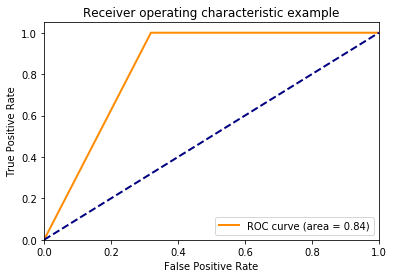

In [64]:
tf.reset_default_graph()
reset_contingency()
(fpr, tpr, roc_auc) = run(withContingency)
plot_roc(0, fpr, tpr, roc_auc)

Generated contingency in iteration  0 : 0
Training Accuracy in iteration  0 : 0.526316
Generated contingency in iteration  50 : 0
Training Accuracy in iteration  50 : 0.954545
Generated contingency in iteration  100 : 0
Training Accuracy in iteration  100 : 1.0
Generated contingency in iteration  150 : 0
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes 199 : 0.998582
Final Accuracy on unexpected data 199 : 0.501458


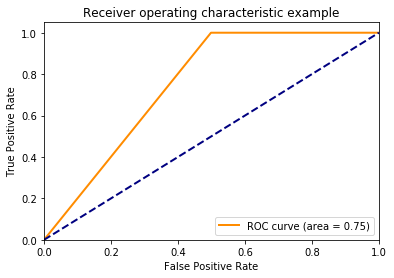

In [65]:
tf.reset_default_graph()
reset_contingency()
(fpr, tpr, roc_auc) = run(withoutContingency)
plot_roc(0, fpr, tpr, roc_auc)

Generated contingency in iteration  0 : 10
Training Accuracy in iteration  0 : 0.473684
Generated contingency in iteration  50 : 510
Training Accuracy in iteration  50 : 1.0
Generated contingency in iteration  100 : 1010
Training Accuracy in iteration  100 : 1.0
Generated contingency in iteration  150 : 1510
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes 199 : 0.998582
Final Accuracy on unexpected data 199 : 0.789474


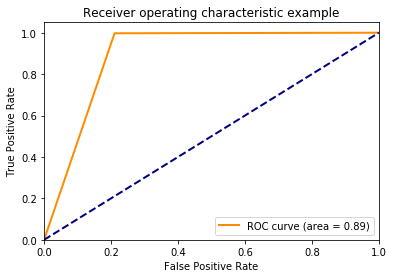

In [66]:
tf.reset_default_graph()
reset_contingency()
(fpr, tpr, roc_auc) = run(withRandomContingency)
plot_roc(0, fpr, tpr, roc_auc)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_roc(i, fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [17]:
np.where(mnist.test.labels >= num_classes)[0].shape[0]

(7885,)

In [46]:
(imges, lables) = relabel_roc(mnist.test)
np.where(lables == 1)

(array([   2,    4,   11, ..., 9000, 9005, 9014]),)